In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

import numpy as np
import pandas as pd

train_data = pd.read_csv("./house prices/train.csv")
test_data = pd.read_csv("./house prices/test.csv")

In [2]:
print(train_data.shape, test_data.shape)

(1460, 81) (1459, 80)


In [3]:
train_data.iloc[:5, :]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [5]:
# preprocessing
# all_features.select_dtypes(exclude=['object']).apply(lambda x: (x - x.mean()) / x.std()).fillna(0)
num_index = all_features.dtypes[all_features.dtypes != 'object'].index
# calculate z-scores and fill nan
all_features[num_index] = all_features[num_index].apply(lambda x: (x - x.mean()) / x.std()).fillna(0)
# convert obj features into indicators
all_features = pd.get_dummies(all_features, dummy_na=True)

In [6]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values.astype(dtype=np.float32))
train_labels = torch.tensor(train_data['SalePrice'].values.astype(dtype=np.float32)).reshape(-1, 1)  # corresponds to output
test_features = torch.tensor(all_features[n_train:].values.astype(dtype=np.float32))

In [7]:
num_features = train_features.shape[1]

In [8]:
# training
def get_net():
    net = nn.Sequential(nn.Linear(num_features, num_features//2), nn.Linear(num_features//2, 1))
    return net
loss = nn.MSELoss()

In [9]:
def log_rmse(net, features, labels):
    # estimate relative error
    preds = torch.clamp(net(features), min=1)  # to stablize the value when the logarithm is taken by setting min value as 1
    rmse = torch.sqrt(loss(torch.log(preds), torch.log(labels)))
    return rmse.item()

In [10]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, lr, weight_decay, batch_size):
    train_loss, test_loss = [], []
    train_iter = DataLoader(TensorDataset(train_features, train_labels), batch_size, shuffle=True)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    for i in range(num_epochs):
        for x, y in train_iter:
            optimizer.zero_grad()
            yhat = net(x)
            l = loss(yhat, y)
            l.backward()
            optimizer.step()
        train_loss.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_loss.append(log_rmse(net, test_features, test_labels))
        # print("Epoch: {}/{}..\tTraining Loss: {:.3f}.. ".format(i+1, num_epochs, train_loss[-1]))
    return train_loss, test_loss

In [11]:
import matplotlib.pyplot as plt
def semilogy(xv, yv, xl, yl, x2v=None, y2v=None, legend=None, figsize=(3.5, 2.5)):
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.semilogy(xv, yv)
    if x2v and y2v:
        plt.semilogy(x2v, y2v, linestyle=":")
        plt.legend(legend)

In [12]:
# cross validation
def get_k_fold_data(k, i, x, y):
    # return the i-th fold of the data
    assert k > 1
    fold_size = x.shape[0] // k  # floor division
    x_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        x_part, y_part = x[idx], y[idx]
        if j == i:
            x_valid, y_valid = x_part, y_part
        elif x_train is None and y_train is None:
            x_train, y_train = x_part, y_part
        else:
            x_train = torch.cat((x_train, x_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return x_train, y_train, x_valid, y_valid 

In [13]:
def k_fold(k, x_train, y_train, num_epochs, lr, weight_decay, batch_size):
    train_loss_sum, valid_loss_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, x_train, y_train)
        net = get_net()
        train_loss, valid_loss = train(net, *data, num_epochs, lr, weight_decay, batch_size)
        train_loss_sum += train_loss[-1]
        valid_loss_sum += valid_loss[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_loss, 'epochs', 'rmse', range(1, num_epochs + 1), valid_loss, ['train', 'valid'])
        print("fold {}, train rmse: {}, valid rmse: {}".format(i + 1, train_loss[-1], valid_loss[-1]))
    return train_loss_sum / k, valid_loss_sum / k

fold 1, train rmse: 0.1574934422969818, valid rmse: 0.14999933540821075
fold 2, train rmse: 0.15148407220840454, valid rmse: 0.17707708477973938
fold 3, train rmse: 0.15004298090934753, valid rmse: 0.15802262723445892
fold 4, train rmse: 0.1554095447063446, valid rmse: 0.1475226730108261
fold 5, train rmse: 0.151174858212471, valid rmse: 0.17557360231876373
5-fold validation: avg train rmse: 0.153121, avg valid rmse: 0.161639


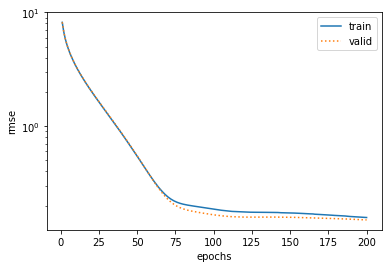

In [14]:
k, num_epochs, lr, weight_decay, batch_size = 5, 200, 0.001, 0, 20
train_loss, valid_loss = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f' % (k, train_loss, valid_loss))

train rmse 0.144897
tensor([[110188.5312],
        [160919.8594],
        [192307.5156],
        ...,
        [201326.2344],
        [106659.1797],
        [240549.8594]])


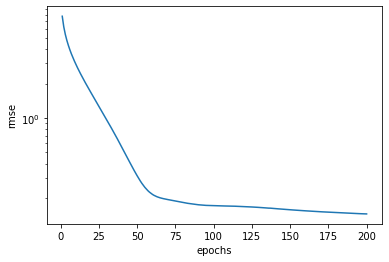

In [15]:
# predict
net = get_net()
train_loss, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
semilogy(range(1, num_epochs + 1), train_loss, 'epochs', 'rmse')
print('train rmse %f' % train_loss[-1])
with torch.no_grad():
    net.eval()
    prediction = net.forward(test_features)
print(prediction)
test_data['SalePrice'] = pd.Series(prediction.reshape(1, -1)[0])
result = pd.concat((test_data['Id'], test_data['SalePrice']), axis=1)
result.to_csv("result.csv", index=False)